# GPT Vision
## Generating structured data from image with GPT 4o and LangChai

Following [this medium post](https://medium.com/@bpothier/generating-structured-data-from-an-image-with-gpt-vision-and-langchain-34aaf3dcb215): 

venv: gpt-vision

In [1]:
import os
from dotenv import load_dotenv
import openai
import base64
import langchain
from langchain.chains import TransformChain
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain import globals
from langchain_core.runnables import chain
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser

# load the OpenAI API key from the .env file
load_dotenv(".env")
openai.api_key = os.getenv("OPENAI_API_KEY")

# # Get an OpenAI API Key before continuing
# if "OPENAI_API_KEY" in os.environ:
#     openai_api_key = os.environ["OPENAI_API_KEY"]
# else:
#     openai_api_key = st.sidebar.text_input("OpenAI API Key", type="password")
# if not openai_api_key:
#     st.info("Enter an OpenAI API Key to continue")
#     st.stop()

# image loader with base64 encoding
def load_image(inputs: dict) -> dict:
    """Load image from file and encode it as base64."""
    image_path = inputs["image_path"]

    def encode_image(image_path):
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")
    image_base64 = encode_image(image_path)
    return {"image": image_base64}

# integrate into langchain pipeline
load_image_chain = TransformChain(
    input_variables=["image_path"],
    output_variables=["image"],
    transform=load_image
)

# define output structure
class ImageInformation(BaseModel):
    """Information about an image."""
    image_description: str = Field(description="a short description of the image")
    people_count: int = Field(description="number of humans in the picture")
    main_objects: list[str] = Field(description="list of the main objects in the picture")
    
## setting of the image model
# ChatOpenAI model is not natively capable of handling both text and image inputs simultaneously
# create a wrapper chain that combines the image loading and encoding steps with the LLM invocation step

# set verbose
globals.set_debug(True)

# decorator to handle duel modalities
@chain
def image_model(inputs: dict) -> str | list[str] | dict:
    """Invoke model with image and prompt."""
    model = ChatOpenAI(
        temperature=0.5, 
        model="gpt-4o",
        max_tokens=1024
        )
    msg = model.invoke(
        [HumanMessage(
            content=[
                {"type": "text", "text": inputs["prompt"]},
                {"type": "text", "text": parser.get_format_instructions()},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{inputs['image']}"}},
            ]
        )
        ]
    )
    return msg.content

parser = JsonOutputParser(pydantic_object=ImageInformation)

def get_image_informations(image_path: str) -> dict:
    vision_prompt = """
    Given the image, provide the following information:
    - A count of how many people are in the image
    - A list of the main objects present in the image
    - A description of the image
    """
    vision_chain = load_image_chain | image_model | parser
    return vision_chain.invoke({"image_path": f"{image_path}",
                                "prompt": vision_prompt})


/opt/anaconda3/envs/gpt-vision/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "image_path": "./images/animorphs2.jpeg",
  "prompt": "\n    Given the image, provide the following information:\n    - A count of how many people are in the image\n    - A list of the main objects present in the image\n    - A description of the image\n    "
}
[chain/start] [chain:RunnableSequence > chain:TransformChain] Entering Chain run with input:
{
  "image_path": "./images/animorphs2.jpeg",
  "prompt": "\n    Given the image, provide the following information:\n    - A count of how many people are in the image\n    - A list of the main objects present in the image\n    - A description of the image\n    "
}
[chain/end] [chain:RunnableSequence > chain:TransformChain] s] Exiting Chain run with output:
{
  "image": "/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUSExMVFhUXGB0aGBgYFx0YFxcaGBoaGBcYGBkYHSggGB4lHRgdITEiJSktLi4uFx8zODMtNygtLisBCgoKDg0OGxAQGy0mICUtLS0tLS0vLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tL
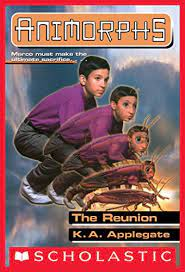

{'image_description': "A book cover for 'Animorphs: The Reunion' depicting a boy transforming into an insect.",
 'people_count': 1,
 'main_objects': ['boy', 'insect', 'book cover', 'text']}

In [5]:
result = get_image_informations("./images/animorphs2.jpeg")
result

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "image_path": "./images/Tito Puente.png",
  "prompt": "\n    Given the image, provide the following information:\n    - A count of how many people are in the image\n    - A list of the main objects present in the image\n    - A description of the image\n    "
}
[chain/start] [chain:RunnableSequence > chain:TransformChain] Entering Chain run with input:
{
  "image_path": "./images/Tito Puente.png",
  "prompt": "\n    Given the image, provide the following information:\n    - A count of how many people are in the image\n    - A list of the main objects present in the image\n    - A description of the image\n    "
}
[chain/end] [chain:RunnableSequence > chain:TransformChain] s] Exiting Chain run with output:
{
  "image": "iVBORw0KGgoAAAANSUhEUgAAA70AAAQ3CAYAAAA0UQmcAAABVGlDQ1BJQ0MgUHJvZmlsZQAAKJFtkDFLw1AUhU80UmhFWnR0yFaVKpL2D9QOKjiEWlGzpWlslSQ+kog6uuskuAlOTg4OSgYHHV1FUHFz0NFFyKIl3peoadULl/txOO9y3wF6RI0xUwRg2Z5TnZ6Sl
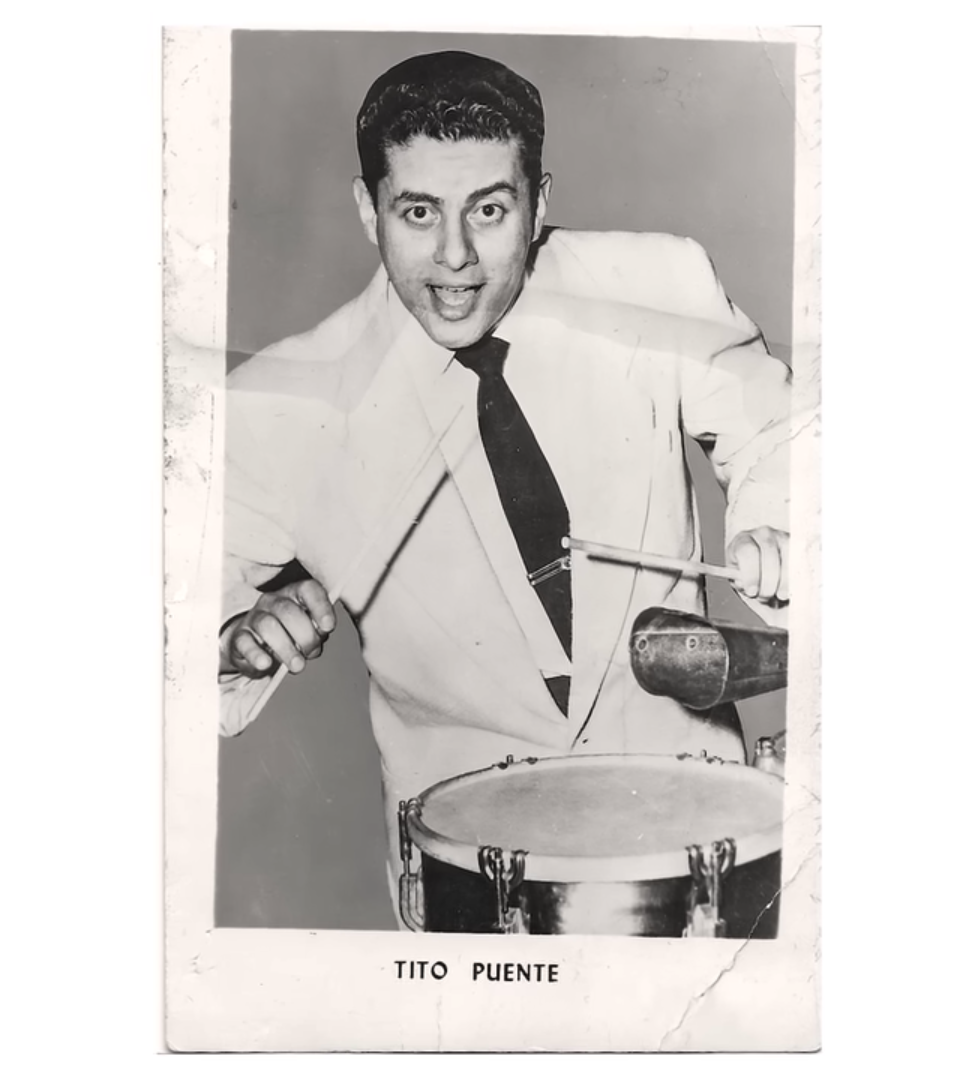

{'image_description': 'A black and white photo of a person playing drums.',
 'people_count': 1,
 'main_objects': ['drums', 'drumsticks', 'person']}

In [7]:
result = get_image_informations("./images/Tito Puente.png")
result